## ライブラリ

In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.unicode.east_asian_width", True)
pd.set_option("display.precision", 3)

## 自己情報量

In [3]:
# 自己情報量を計算する関数
def self_info(prob):
  return -1 * np.log2(prob)

In [8]:
# サイコロで６の目が出たとわかったときの自己情報量
i_6 = self_info(1/6)
print(f"6の目が出たとわかったときの自己情報量：{i_6:.3g}")

6の目が出たとわかったときの自己情報量：2.58


In [11]:
# 6の目が出たとわかったときの自己情報量＝3の倍数が出たとわかったときの自己情報量＋偶数が出たとわかったときの自己情報量
i_3mul = self_info(1/3)
i_even = self_info(1/2)
print(f"3の倍数とわかったときの自己情報量：{i_3mul:.3g}")
print(f"偶数とわかったときの自己情報量：{i_even:.3g}")
print(f"情報を小出しにされたときの合計値：{i_3mul + i_even:.3g}")

3の倍数とわかったときの自己情報量：1.58
偶数とわかったときの自己情報量：1
情報を小出しにされたときの合計値：2.58


## 平均情報量（エントロピー）

In [12]:
# 好況と不況の確率
prob_state = pd.Series([0.4, 0.6])
prob_state.index = ["好況", "不況"]
prob_state

好況    0.4
不況    0.6
dtype: float64

In [13]:
# エントロピーの計算
H = prob_state[0] * self_info(prob_state[0]) + prob_state[1] * self_info(prob_state[1])
print(f"{H:.3g}")

0.971


In [16]:
# scipyのentropy関数を利用してエントロピーを計算
from scipy.stats import entropy
H_stats = entropy(prob_state, base = 2)
print(f"{H_stats:.3g}")

0.971


In [18]:
# 確率の合計が1になっていない場合は勝手に標準化される
H_normalize = entropy(pd.Series([0.2, 0.3]), base = 2)
print(f"{H_normalize:.3g}")

0.971


In [19]:
# 11種類の確率分布を作成
prob_df = pd.DataFrame({
    "p1": np.arange(start = 0, stop = 1.1, step = 0.1), 
    "p2": 1 - np.arange(start = 0, stop = 1.1, step = 0.1)
})
prob_df

,p1,p2
0,0.0,1.0
1,0.1,0.9
2,0.2,0.8
3,0.3,0.7
4,0.4,0.6
5,0.5,0.5
6,0.6,0.4
7,0.7,0.3
8,0.8,0.2
9,0.9,0.1


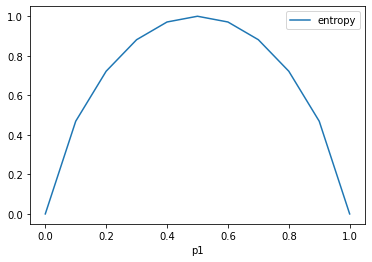

In [33]:
# 各行に対してentropy関数を適用
prob_df["entropy"] = prob_df[["p1", "p2"]].apply(entropy, axis = 1, base = 2)

# 図示
prob_df.plot(x = "p1", y = "entropy")

## 相互情報量

In [37]:
# 自然の状態に対する予測値と実測値の同時分布
joint_forecast_state = pd.DataFrame({
    "好況予測": [0.35, 0.1], 
    "不況予測": [0.05, 0.5]
})
joint_forecast_state.index = ["好況", "不況"]
joint_forecast_state

,好況予測,不況予測
好況,0.35,0.05
不況,0.10,0.50


In [40]:
# 予測値の周辺分布P(f1), P(f2)：列ごとの和をとる
marginal_forecast = joint_forecast_state.sum(axis = 0)
marginal_forecast

好況予測    0.45
不況予測    0.55
dtype: float64

In [41]:
# 実測値の周辺分布P(θ1), P(θ2)：行ごとに和をとる
marginal_state = joint_forecast_state.sum(axis = 1)
marginal_state

好況    0.4
不況    0.6
dtype: float64

In [44]:
# 条件付き分布：P(θ|f)
conditional_forecast = joint_forecast_state.div(marginal_forecast, axis = 1)
conditional_forecast

,好況予測,不況予測
好況,0.778,0.091
不況,0.222,0.909


In [45]:
# 条件付きエントロピー

# まずは好況予測が出た後の情報エントロピーH(θ|f1)と不況予測が出た後の情報エントロピーH(θ|f2)を計算
H_by_f = conditional_forecast.apply(entropy, axis = 0, base = 2)
H_by_f

好況予測    0.764
不況予測    0.439
dtype: float64

In [48]:
# 予測が得られた後の条件付きエントロピー
H_conditional = H_by_f.mul(marginal_forecast).sum()
print(f"{H_conditional:.3g}")

0.586


In [49]:
# 相互情報量

# まずは自然の状態が持つもともとの不確実性H(θ)
H_state = entropy(marginal_state, base = 2)
print(f"{H_state:.3g}")

0.971


In [50]:
# 相互情報量＝もともとの不確実性H(θ)－予測後に残った不確実性H(θ|f)
MI = H_state - H_conditional
print(f"{MI:.3g}")

0.385


## 相互情報量の計算例

In [51]:
# 同時分布を入力して相互情報量を返す関数
def calc_mi(joint_prob_df):
  marginal_forecast = joint_prob_df.sum(axis = 0)
  marginal_state = joint_prob_df.sum(axis = 1)
  conditional_forecast = joint_prob_df.div(marginal_forecast, axis = 1)
  H_by_f = conditional_forecast.apply(entropy, axis = 0, base = 2)
  H_conditional = H_by_f.mul(marginal_forecast).sum()
  H_state = entropy(marginal_state, base = 2)
  MI = H_state - H_conditional
  return MI

In [52]:
# 動作確認
print(f"需要予測の相互情報量：{calc_mi(joint_forecast_state):.3g}")

需要予測の相互情報量：0.385


In [54]:
# コイン投げ予測の相互情報量
coin_result = pd.DataFrame({
    "好況予測": [0.2, 0.3], 
    "不況予測": [0.2, 0.3]
})
coin_result.index = ["好況", "不況"]
print(f"コイン投げ予測の相互情報量：{calc_mi(coin_result):.3g}")

コイン投げ予測の相互情報量：0


In [55]:
# 完全的中予測の相互情報量
perfect_forecast = pd.DataFrame({
    "好況予測": [0.4, 0], 
    "不況予測": [0, 0.6]
})
perfect_forecast.index = ["好況", "不況"]
print(f"完全的中予測の相互情報量：{calc_mi(perfect_forecast):.3g}")

完全的中予測の相互情報量：0.971


In [56]:
# 完全情報が持つ相互情報量は，自然の状態が持つもともとの不確実性に一致する（＝予測後に残った不確実性がゼロ）
marginal_state = perfect_forecast.sum(axis = 1)
H_state = entropy(marginal_state, base = 2)
print(f"自然の状態が持つもともとの不確実性：{H_state:.3g}")

自然の状態が持つもともとの不確実性：0.971


In [57]:
# 天邪鬼予測の相互情報量
perversity_forecast = pd.DataFrame({
    "好況予測": [0, 0.6], 
    "不況予測": [0.4, 0]
})
perversity_forecast.index = ["好況", "不況"]
print(f"天邪鬼予測の相互情報量：{calc_mi(perversity_forecast):.3g}")

天邪鬼予測の相互情報量：0.971


## 相対エントロピー（KL情報量）

In [59]:
# 予測f_kごとの条件付き分布
conditional_boom = conditional_forecast["好況予測"]
conditional_slump = conditional_forecast["不況予測"]

In [60]:
# 好況予測における相対エントロピー
conditional_boom[0] * np.log2(conditional_boom[0] / marginal_state[0]) + conditional_boom[1] * np.log2(conditional_boom[1] / marginal_state[1])

0.4277319215518185

In [61]:
# entropy関数を使う
KL_boom = entropy(conditional_boom, base = 2, qk = marginal_state)
print(f"好況予測の相対エントロピー：{KL_boom:.3g}")

好況予測の相対エントロピー：0.428


In [62]:
# 不況予測の相対エントロピー
KL_slump = entropy(conditional_slump, base = 2, qk = marginal_state)
print(f"不況予測の相対エントロピー：{KL_slump:.3g}")

不況予測の相対エントロピー：0.351


In [63]:
# apply関数を使えばまとめて計算可能
KL = conditional_forecast.apply(entropy, axis = 0, base = 2, qk = marginal_state)
KL

好況予測    0.428
不況予測    0.351
dtype: float64

In [64]:
# 相対エントロピーは対称性を満たさない
KL_boom2 = entropy(marginal_state, base = 2, qk = conditional_boom)
print(f"好況予測の相対エントロピー：{KL_boom:.3g}")
print(f"好況予測の相対エントロピー（順序逆）：{KL_boom2:.3g}")

好況予測の相対エントロピー：0.428
好況予測の相対エントロピー（順序逆）：0.476


## 相対エントロピーと相互情報量の関係

In [69]:
# 相互情報量＝予測値ごとの相対エントロピーについて予測の周辺分布で期待値をとったもの

# 相対エントロピーの期待値
mean_KL = KL.mul(marginal_forecast).sum()
print(f"相対エントロピーの期待値：{mean_KL:.3g}")
print(f"相互情報量：{calc_mi(joint_forecast_state):.3g}")

相対エントロピーの期待値：0.385
相互情報量：0.385
